In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles, venn3
%matplotlib inline

class Compound:
    def __init__(self,
                formulas = [],
                adducts = [],
                description = "",
                precursor_mz = 0.0,
                charge = "",
                rt = "",
                fragment_mz = [],
                fragment_int = []):
        self.formulas = formulas
        self.adducts = adducts
        self.description = description
        self.precursor_mz = precursor_mz
        self.charge = charge
        self.rt = rt
        self.fragment_mz = fragment_mz
        self.fragment_int = fragment_int
    
class Matches:
    def __init__(self,
                 overlapping_oms = [],
                 non_overlapping_oms = [],
                 overlapping_mdia = [],
                 non_overlapping_mdia = [],
                 overlapping_rt_dict = {},
                 overlapping_formula_dict = {}):
        self.overlapping_oms = overlapping_oms
        self.non_overlapping_oms = non_overlapping_oms
        self.overlapping_mdia = overlapping_mdia
        self.non_overlapping_mdia = non_overlapping_mdia
        self.overlapping_rt_dict = overlapping_rt_dict
        self.overlapping_formula_dict = overlapping_formula_dict
        
def useCompoundMass(compound):
    return compound.precursor_mz

# comparison based on molecular_formula, adduct and the retention time 
def compareBySumAddRt(mdia_lib, oms_lib, rt_dev):
    oms_dict = {}
    for compound in oms_lib:
        # index 0, since oms only one formula and adduct
        key = str(compound.formulas[0] + "_" + compound.adducts[0])
        new_value = []
        new_value.append(compound.rt)
        if key in oms_dict:
            current_value = oms_dict[key]
            combined_value = current_value + new_value
            oms_dict[key] = combined_value
        else:
            oms_dict[key] = new_value

    overlapping_rt_dict = {}  
    overlapping_formula_dict = {}
    not_in_dictionary = [] # compounds which had no match 
    in_dictionary = [] # compounds which had a match
    valid_lookup_keys = [] # key which had a match in the oms_dict
    for compound in mdia_lib:
        l_size = len(compound.formulas)
        for i in range(0,l_size):
            key = str(compound.formulas[i] + "_" + compound.adducts[i])
            #print(key)
            if key in oms_dict:
                current_entry = oms_dict[key]
                #print(current_entry)
                # iterate over rt in dict_oms
                for j in range(0,len(current_entry)):
                    # check if retention time within a certain threshold
                    min_rt = current_entry[j] - rt_dev
                    max_rt = current_entry[j] + rt_dev
                    #print("c_entry: " + str(current_entry[j]))
                    #print("m_entry: " + str(compound.rt))
                    #print("min_rt: " + str(min_rt))
                    #print("max_rt: " + str(max_rt))
                    rt_bool = float(compound.rt) >= float(min_rt) and float(compound.rt) <= float(max_rt)
                    #print(rt_bool)
                    if (rt_bool):
                        des = []
                        descriptions = compound.description.split(";")
                        for element in descriptions:
                            des.append(re.sub("_.*$","",element))
                        description = ';'.join(des)
                        if compound.rt in overlapping_rt_dict:
                            overlapping_rt_dict[compound.rt].append(current_entry[j])
                        else:
                            l_rt = [current_entry[j]]
                            overlapping_rt_dict[compound.rt] = l_rt  
                        if description in overlapping_formula_dict:
                            overlapping_formula_dict[description].append(str(key))
                        else:
                            l_key = [str(key)]
                            overlapping_formula_dict[description] = l_key
                        in_dictionary.append(compound) # save mdia entry ## TODO happens to often 
                        lookup_key = str(str(key) + "_" + str(current_entry[j]))
                        valid_lookup_keys.append(lookup_key)

    # Resolve overlapping / non_overlapping compounds in oms
    overlapping_compounds_oms = []
    non_overlapping_compounds_oms = []
    for compound in oms_lib:
        lookup = str(compound.formulas[0] + "_" + compound.adducts[0] + "_" + str(compound.rt))
        if lookup in valid_lookup_keys:
            overlapping_compounds_oms.append(compound)
        else:
            non_overlapping_compounds_oms.append(compound)

    # Resolve overlapping / non_overlapping compounds in mdia 
    overlapping_compounds_mdia = []
    non_overlapping_compounds_mdia = []
    in_dictionary = set(in_dictionary)
    for compound in mdia_lib:
        if compound in in_dictionary:
            #print("overlapping:" + compound.description)
            overlapping_compounds_mdia.append(compound)
        else:
            non_overlapping_compounds_mdia.append(compound)
            
    matches = Matches()
    matches.overlapping_oms = overlapping_compounds_oms
    matches.non_overlapping_oms = non_overlapping_compounds_oms
    matches.overlapping_mdia = overlapping_compounds_mdia
    matches.non_overlapping_mdia = non_overlapping_compounds_mdia
    matches.overlapping_rt_dict = overlapping_rt_dict
    matches.overlapping_formula_dict = overlapping_formula_dict
    
    return matches

def read_metabodia_library(in_library_path):

    compoundlist = []
    description = ""

    file = open(in_library_path, 'r')
    line = file.readline()
    index = 0
    while line: 
        line = line.strip()
        lastlineoffileemtpy = len(line.strip()) == 0
        if line.startswith("Putative_formula_MS1:") or lastlineoffileemtpy:
            if (index == 0):
                compound = Compound()
            if (description != ""):
                compoundlist.append(compound)
                compound = Compound()
                compound.formulas = []
                compound.adducts = []
                compound.fragment_mz = []
                compound.fragment_int = []
            description = line.split(" ")[1].strip()
            compound.description = description
            for element in description.split(";"):
                index_1 = element.index("^")
                index_2 = element.index("_")
                compound.formulas.append(element[0:index_1])
                compound.adducts.append(str("[" + element[index_1+1:index_2] + "]+")) # TODO: Not sure if that works for all cases. Here only charge 1. 
        if line.startswith("Precursor m/z:"):
            compound.precursor_mz = float(line.split(" ")[2])
        if line.startswith("Charge state:"):
            compound.charge = line.split(" ")[2]
        if line.startswith("RT:"):
            compound.rt = line.split(" ")[1]
        if line.startswith(tuple('0123456789')):
            compound.fragment_mz.append(line.split("\t")[0].strip())
            compound.fragment_int.append(line.split("\t")[1].strip("\n").strip())
        line = file.readline()
        index += 1

    file.close()
    compoundlist.sort(key=useCompoundMass)
    return(compoundlist)

def read_openms_assay_library(openmslib_path):
    compoundlist = []
    d_lib = dict()
    df_assay_lib = pd.read_csv(openmslib_path, sep = '\t')

    # filter decoys
    df_assay_lib = df_assay_lib[df_assay_lib['Decoy'] == 0]

    unique_tgid = df_assay_lib.TransitionGroupId.unique()
    for element in unique_tgid:
        d_lib[element] = df_assay_lib[df_assay_lib['TransitionGroupId'] == element]

    for key, value in d_lib.items():
        compound = Compound()
        # filter empty entries 
        if not value['SumFormula'].unique(): 
            continue
        compound.formulas = value['SumFormula'].unique()
        compound.adducts = value['Adducts'].unique()
        compound.description = value['CompoundName'].unique()[0]
        compound.precursor_mz = value['PrecursorMz'].unique()[0]
        compound.charge = value['PrecursorCharge'].unique()[0]
        compound.rt = value['NormalizedRetentionTime'].unique()[0]
        compound.fragment_mz = value['ProductMz'].tolist()
        compound.fragment_int = value['LibraryIntensity'].tolist()
        compoundlist.append(compound)
    
    compoundlist.sort(key=useCompoundMass)
    return compoundlist

def read_oms_quant(df):
    compoundlist = []
    for ind in df.index: 
        compound = Compound()
        formula_adduct = re.sub("^\d*_","", df['Protein'][ind])
        compound.formulas = [formula_adduct.split('_')[0]]
        compound.adducts = [formula_adduct.split('_')[1]]
        compound.rt = df['RT'][ind]
        compoundlist.append(compound)
    return compoundlist

def read_mdia_quant(rt_corrected_df):
    compoundlist = []
    for ind in rt_corrected_df.index: 
        compound = Compound()
        formulas = []
        adducts = []
        for element in rt_corrected_df['Protein'][ind].split(";"):
            index_1 = element.index("^")
            formulas.append(element[0:index_1])
            adducts.append(str("[" + element[index_1+1:] + "]+"))
        compound.formulas = formulas
        compound.adducts = adducts
        compound.description = rt_corrected_df['Protein'][ind]
        compound.rt = rt_corrected_df['RT'][ind]
        compoundlist.append(compound)
    return compoundlist

def read_mdia_oms_quant(df):
    compoundlist = []
    for ind in df.index: 
        compound = Compound()
        formulas = []
        adducts = []
        multiple_compounds = re.sub("^\d*_","", df['Protein'][ind])
        for element in multiple_compounds.split(";"):
            index_1 = element.index("^")
            formulas.append(element[0:index_1])
            adducts.append(str("[" + element[index_1+1:] + "]+"))
        compound.formulas = formulas
        compound.adducts = adducts
        compound.rt = df['RT'][ind]
        compoundlist.append(compound)
    return compoundlist

def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))


In [2]:
## This comparsion is purely based on molecular formula and adduct combination
## the dataset without taking the retention time into account!
## This makes it much easier to compare, but identification with the same molecular formula, adduct
## combination at a different retention time are lost.

# libraries
mdia_lib_p = "/Volumes/elements/MetaboDIA/comparison/metabodia/DDA_msconvert_mzXML_10ppm_min_s02_pf00.txt"
oms_lib_p = "/Volumes/elements/MetaboDIA/comparison/agm/20201129_s45_mt1_resolve_totoc_67_02.tsv"
comb_lib_p = "/Volumes/elements/MetaboDIA/Option_1/combined_library_02_67/prepare_lib/20201215_combined_mdiaoms_library_67.tsv"
oms_lib_p_uk = "/Volumes/elements/MetaboDIA/comparison/agm/20201129_s45_mt1_resolve_unknown_totoc_67_02.tsv"

# rt mapping
mdia_quant_mapping_p = "/Volumes/elements/MetaboDIA/comparison/mapDIA_analysis/mdia_10ppm_25ppm_min_spec_02_pf00/DIA_msconvert_mzxml_centroided_25ppm_min_s02_pf00_mapping.txt"

# quantification
mdia_quant_p = "/Volumes/elements/MetaboDIA/comparison/mapDIA_analysis/mdia_10ppm_25ppm_min_spec_02_pf00/protein_level_mdia_10ppm_25ppm_min_spec_02_pf00_format.txt"
#mdia_quant_p = "/Volumes/elements/MetaboDIA/comparison/mapDIA_analysis/mdia_10ppm_25ppm_min_spec_02_pf00/DIA_msconvert_mzxml_centroided_25ppm_min_s02_pf00_mapping.txt"

mdia_oms_quant_p = "/Volumes/elements/MetaboDIA/comparison/mapDIA_analysis/oms_mdia_10ppm_25ppm_min_spec_02_pf00/20201205_oms_mdia_10ppm_25ppm_min_spec_02_pf00_DIAlignR_std_linear_mapping.tsv"
oms_quant_p = "/Volumes/elements/MetaboDIA/comparison/mapDIA_analysis/s45_mt1_resolve_totoc_02_67/20201214_s45_mt1_resolve_totoc_02_67_DIAlignR_std_linear_mapping.tsv"
comp_quant_p = "/Volumes/elements/MetaboDIA/comparison/mapDIA_analysis/combined_library_02_67/20201214_combined_library_02_67_DIAlignR_std_linear_mapping.tsv"

oms_quant_p_uk = "/Volumes/elements/MetaboDIA/comparison/mapDIA_analysis/s45_mt1_resolve_unknown_totoc_02_67/20201214_s45_mt1_resolve_unknown_totoc_02_67_DIAlignR_std_linear_mapping.tsv"

# read the library
mdia_lib_cl = read_metabodia_library(mdia_lib_p)

count_compounds_less_3_fragments_02 = 0
mdia_lib = []
for element in mdia_lib_cl:
    if len(element.fragment_mz) < 3:
        count_compounds_less_3_fragments_02 +=1
    else:
        mdia_lib.append(element)
print("count_compounds_less_3_fragments_02: " + str(count_compounds_less_3_fragments_02))

oms_lib = read_openms_assay_library(oms_lib_p) 
comb_lib = read_openms_assay_library(comb_lib_p)
oms_lib_uk = read_openms_assay_library(oms_lib_p_uk)

# read the quant
mdia_quant_mapping = pd.read_csv(mdia_quant_mapping_p, sep = '\t')
mdia_quant = pd.read_csv(mdia_quant_p, sep = '\t')

mdia_quant = mdia_quant.drop(columns=['RT'])
mdia_oms_quant = pd.read_csv(mdia_oms_quant_p, sep = '\t')
oms_quant = pd.read_csv(oms_quant_p, sep = '\t')
comb_quant = pd.read_csv(comp_quant_p, sep = '\t')
oms_quant_uk = pd.read_csv(oms_quant_p_uk, sep = '\t')

#### use mdia_quant_mapping_p to recover the RT on protein level! 
mdia_quant_mapping = mdia_quant_mapping[['Protein', 'RT']]
mdia_quant_mapping = mdia_quant_mapping.drop_duplicates()
mdia_quant = pd.merge(mdia_quant, mdia_quant_mapping, left_on='Protein', right_on='Protein')

## mdia - mdia
mdia_lib_list = []
for comp in mdia_lib:
    des = []
    descriptions = comp.description.split(";")
    for element in descriptions:
        des.append(re.sub("_.*$","",element))
    description = ';'.join(des)
    mdia_lib_list.append(str(description))

mdia_quant_list = mdia_quant['Protein'].tolist()

## mdia - mdia-oms
mdia_oms_quant_list = []
for element in mdia_oms_quant['Protein'].tolist():
    element = re.sub("^\d*_","",element)
    mdia_oms_quant_list.append(element)

## Set is unique - so probably the ones with different retention time are gone!! 
## 460 536 440
## Yes, when using a set it adds up! But has no reference to retention time for probably different compounds 
## lipids

## oms - oms 
oms_lib_list = []
for element in oms_lib:
    oms_lib_list.append(str(element.formulas[0] + "_" + str(element.adducts[0])))

oms_quant_list = []
for element in oms_quant['Protein'].tolist():
    element = re.sub("^\d*_","",element)
    oms_quant_list.append(element)
    
## oms_uk + oms_uk
oms_lib_list_uk = []
for element in oms_lib_uk:
    oms_lib_list_uk.append(str(element.formulas[0] + "_" + str(element.adducts[0])))

oms_quant_list_uk = []
for element in oms_quant_uk['Protein'].tolist():
    element = re.sub("^\d*_","",element)
    oms_quant_list_uk.append(element)
        
## comb - comb
comb_lib_list = []
for element in comb_lib:
    comb_lib_list.append(str(element.formulas[0] + "_" + str(element.adducts[0])))

comb_quant_list = []
for element in comb_quant['Protein'].tolist():
    element = re.sub("^\d*_","",element)
    comb_quant_list.append(element)
    

########################################################################################

## Parse into compound structure -> reuse the library mapping function for quant data. 
## mdia/mdia_oms vs oms
oms_sar = read_oms_quant(oms_quant)
mdia_sar = read_mdia_quant(mdia_quant)
mdia_oms_sar = read_mdia_oms_quant(mdia_oms_quant) 
comp_sar = read_oms_quant(comb_quant)

## TODO could that be for compareBySumAddRt not works due to description missing? 
rt_dev = 10
mdia_vs_oms = compareBySumAddRt(mdia_sar, oms_sar, rt_dev)
mdia_oms_vs_oms = compareBySumAddRt(mdia_oms_sar, oms_sar, rt_dev)
print(len(mdia_vs_oms.non_overlapping_oms))
print(len(mdia_vs_oms.non_overlapping_mdia))
print(len(mdia_vs_oms.overlapping_oms))
print(len(mdia_vs_oms.overlapping_mdia))

print("mdia_vs_oms.non_overlapping_mdia")
for element in mdia_vs_oms.non_overlapping_mdia:
    print(element.description)


count_compounds_less_3_fragments_02: 76
638
21
40
34
mdia_vs_oms.non_overlapping_mdia
C26H51NO4S^M+Na;C24H50NO7P^M+H;C29H47NO4^M+Na
C27H45O10P^M+Na;C33H34N4O6^M+H
C28H48O5^M+K;C31H44O4^M+Na;C24H49O7P^M+Na;C29H46F2O2^M+K
C28H54NO8P^M+K
C30H42O11^M+Na
C30H42O11^M+Na
C31H64NO9P^M+Na
C32H66NO7P^M+K
C33H59O16P^M+Na
C33H64NO9P^M+H
C34H63O14P^M+Na;C38H62O12^M+K
C36H67NO4^M+K
C37H67NO12^M+Na;C39H65NO12^M+H;C38H72NO8P^M+K
C38H71NO4^M+K
C39H71O22P^M+K
C39H72NO7P^M+K
C41H76NO8P^M+K
C43H72NO6P^M+K;C39H72NO10P^M+Na;C41H70NO10P^M+H
C44H78NO11P^M+H;C42H79NO13^M+Na;C48H78NO8P^M+H;C43H84NO9P^M+K;C46H80NO8P^M+Na
C47H89NO9^M+K;C47H90NO7P^M+K
C49H94NO8P^M+K


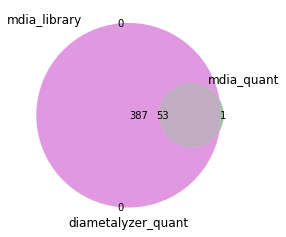

In [3]:
## Compare mdia (lib, quant) + mdia_oms (quant)
v01 = venn3([set(mdia_lib_list), set(mdia_quant_list), set(mdia_oms_quant_list)],
            ('mdia_library','mdia_quant', 'diametalyzer_quant'))


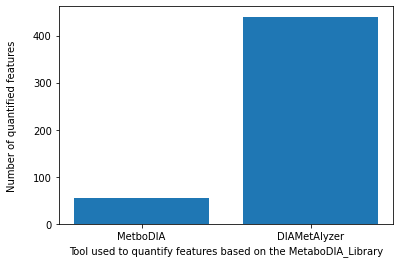

In [4]:
x = ['MetaboDIA', 'DIAMetAlyzer']
yquant = [54, 440]

fig, ax = plt.subplots() 
plt.bar(x,yquant)
  
plt.ylabel('Number of quantified features\n')
plt.xlabel('Tool used to quantify features based on the MetaboDIA_Library')

plt.savefig('/Users/alka/Documents/work/projects/DIAMetAlyzer_all/OSW_inkscape/publication/2021/features_quant_metabodia_library.svg', format="svg")

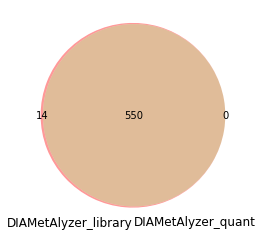

In [5]:
## Compare OMS lib to OMS Quant
v03 = venn2([set(oms_lib_list), set(oms_quant_list)],
            ('DIAMetAlyzer_library','DIAMetAlyzer_quant'))


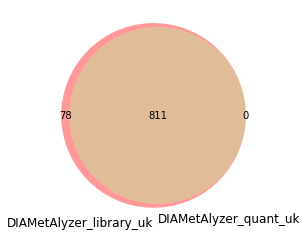

In [6]:
## Compare OMS lib unknown to OMS Quant unknown
v03 = venn2([set(oms_lib_list_uk), set(oms_quant_list_uk)],
            ('DIAMetAlyzer_library_uk','DIAMetAlyzer_quant_uk'))


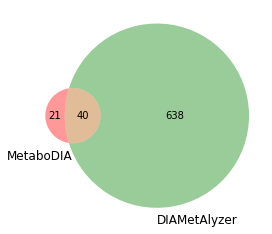

In [7]:
# Quant mdia vs oms
to_plot = mdia_vs_oms
venn2(subsets = (len(to_plot.non_overlapping_mdia), 
                 len(to_plot.non_overlapping_oms),
                 len(to_plot.overlapping_oms)), 
                 set_labels = ('MetaboDIA', 'DIAMetAlyzer'))


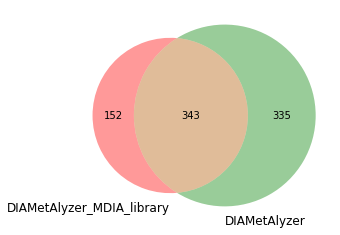

In [8]:
# Quant mdia vs oms
to_plot = mdia_oms_vs_oms
venn2(subsets = (len(to_plot.non_overlapping_mdia), 
                 len(to_plot.non_overlapping_oms),
                 len(to_plot.overlapping_oms)), 
                 set_labels = ('DIAMetAlyzer_MDIA_library', 'DIAMetAlyzer'))

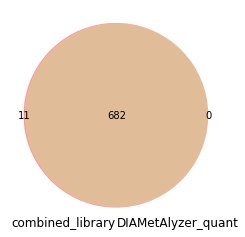

In [9]:
## Compare comb lib to comb Quant
v03 = venn2([set(comb_lib_list), set(comb_quant_list)],
            ('combined_library','DIAMetAlyzer_quant'))

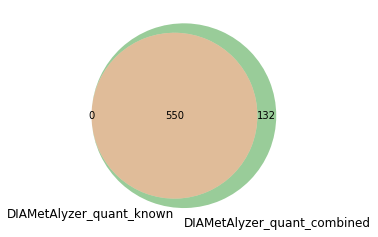

In [10]:
v04 = venn2([set(oms_quant_list), set(comb_quant_list)],
            ('DIAMetAlyzer_quant_known','DIAMetAlyzer_quant_combined'))

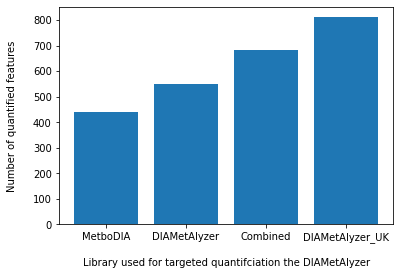

In [11]:
x = ['MetaboDIA', 'DIAMetAlyzer', "Combined", "DIAMetAlyzer_UK"]
yquant = [440, 550, 682, 811]

fig, ax = plt.subplots() 
plt.bar(x,yquant)

labels = ['n = 440', 'n = 550', 'n = 682', 'n = 811']
  
plt.ylabel('Number of quantified features\n')
plt.xlabel('\nLibrary used for targeted quantifciation the DIAMetAlyzer')

   
#plt.show()
plt.savefig('/Users/alka/Documents/work/projects/DIAMetAlyzer_all/OSW_inkscape/publication/2021/features_quant.svg', format="svg")